### SARIMAX modeling of a month with EDA

##### Shane Caldwell

Oh, July. The hottest of all months. Perfect for spending time on the internet doing crime. 

Packets dropped that were coming from a destination in China were put into 10 minutes intervals and displayed as follows. 

In [3]:
import pandas as pd

In [4]:
col_names = ['timestamp', 'dropped', 'num_darknet', 'total_len', 'num_tcp', 'num_udp', 'num_other', 'extra']

df = pd.read_csv('../data/full_month.csv', header = None, names = col_names)
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df = df.sort_values(by='timestamp')
df.timestamp = pd.to_datetime(df.timestamp)

Next, we join the two additional jobs we did for the number of unique regions and number of unique destination ports with timestamp as the key to join.

In [5]:
col_names = ['timestamp', 'num_unique_regions']
unique_regions = pd.read_csv('../data/num_unique_Akamai_regions_full_month_unsorted.csv', header = None, names = col_names)

unique_regions['timestamp'] = pd.to_datetime(unique_regions['timestamp'],unit='s')
unique_regions = unique_regions.sort_values(by='timestamp')
unique_regions.timestamp = pd.to_datetime(unique_regions.timestamp)

col_names =['timestamp', 'num_unique_dst_ports']

unique_dest_ports = pd.read_csv('../data/num_unique_dest_ports_full_month_unsorted.csv', header = None, names = col_names)
unique_dest_ports['timestamp'] = pd.to_datetime(unique_dest_ports['timestamp'], unit='s')
unique_dest_ports = unique_dest_ports.sort_values(by='timestamp')
unique_dest_ports.timestamp = pd.to_datetime(unique_dest_ports.timestamp)

In [6]:
####mad joins on df, unique_regions, unique_dest_ports
df2 = pd.merge(df, unique_regions, on = 'timestamp')
akamai = pd.merge(df2, unique_dest_ports, on = 'timestamp')
akamai.drop(columns='extra', inplace=True)

The timestamps arrive as a unixstamp, which is the 'current unix timestamp'. This is the raw number of seconds Jan 01 1970 (the beginning of the epoch). It's in UTC, or "coordinated universal time". 

UTC is great for computers, but we'd like to be able to look at this from the perspective of China, so let's shift the timestamp to China time!

In most other countries, this would be impossible. China is big - and has several timezones. Right? WRONG. 

China is geographically large enough for 5 timezones, but they all operate off of "China Standard Time" which is Beijing time. The communist party put this forward in 1949 for the purpose of national unity. It's 8 hours ahead of UTC. 

Quora suggests the workweek is essentially the same as in the US, so 9-6 or so is standard.
https://www.quora.com/What-is-the-normal-work-week-in-China-Do-the-Chinese-then-party-down-on-Friday-Saturday-night

In [7]:
from dateutil import tz
from datetime import datetime

def convert_to_chinatime(x):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Shanghai')
    x = x.replace(tzinfo=from_zone)
    china = x.astimezone(to_zone)
    return china

akamai.timestamp = akamai.timestamp.apply(convert_to_chinatime)
akamai['day_of_week'] = akamai['timestamp'].apply(lambda row: row.weekday())
akamai.index= pd.to_datetime(akamai.timestamp)
akamai.drop(['timestamp'], axis=1, inplace=True)

What does that look like? 

In [8]:
#import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5] # figures are too small in these notebooks


fig, ax = plt.subplots()
ax = akamai.plot(ax = ax)
#plt.xticks(xi, df.index)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
plt.show()

"""
Make it a time series plot

log scale should help. and in think length is currently in bytes, so we could convert it to MB or GB

Kevin suggested scaling everything between 0 and 1
"""

<Figure size 1000x500 with 1 Axes>

'\nMake it a time series plot\n\nlog scale should help. and in think length is currently in bytes, so we could convert it to MB or GB\n\nKevin suggested scaling everything between 0 and 1\n'

Now that we're looking on the day level, this doesn't help us very much. It would be better if we could color the graph by day of the week, or at least weekday vs weekend. 

I need to convert these timestamps to get days of the week, then we can use that to make is_weekend features. 


Is the data stationary? It doesn't necessarily look like it, but let's use the Augmented Dickey-Fuller test to confirm. 

In [9]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
dropped = akamai['dropped']
print('---------- Augmented Dickey-Fuller(pre-difference) ---------')
result = adfuller(dropped)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
print('--------------------------------------------')

---------- Augmented Dickey-Fuller(pre-difference) ---------
ADF Statistic: -13.412669
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
--------------------------------------------


We run the Augmented Dickey-Fuller test and fail to reject the null hypothesis that the time series has a unit root. This means it is non-stationary. Let's take the difference and see what that looks like. 

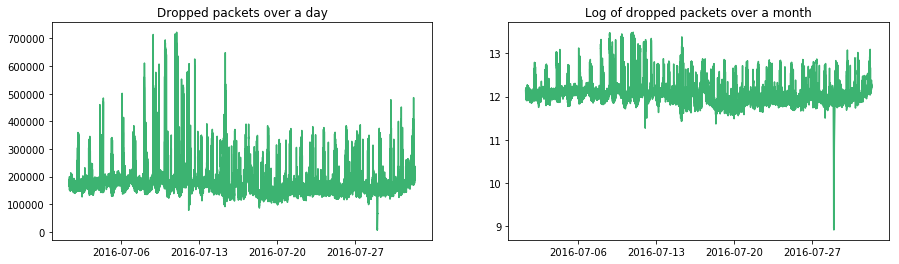

In [10]:
### Take log
import numpy as np
import matplotlib.pyplot as plt

akamai['ln_dropped'] = np.log(akamai['dropped'])

# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
# Levels
axes[0].plot(akamai.index._mpl_repr(), akamai['dropped'], '-', color='mediumseagreen')
axes[0].set(title='Dropped packets over a day')
# Log difference
axes[1].plot(akamai.index._mpl_repr(), akamai['ln_dropped'], '-', color='mediumseagreen')
axes[1].set(title='Log of dropped packets over a month');
plt.show()

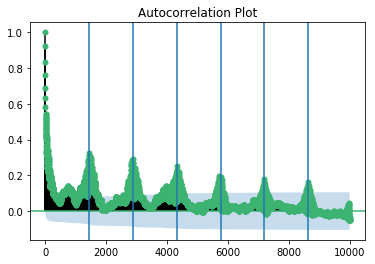

In [11]:
#Increasing label size and image size
#plt.rcParams.update({'font.size': 22})
#plt.figure(figsize = (24,16))

#Plotting 
sm.graphics.tsa.plot_acf(akamai.iloc[1:]['dropped'], lags=10000, ax=plt.gca(), title="Autocorrelation Plot", color='mediumseagreen')

xcoords = [1440, 2880, 4320, 5760, 7200, 8640]
for xc in xcoords:
    plt.axvline(x=xc)

plt.savefig('acf_plot.png')

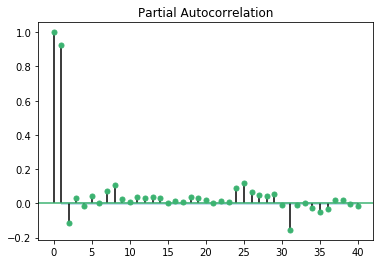

In [12]:
#plt.rcParams.update({'font.size': 22})
#plt.figure(figsize = (24,16))
sm.graphics.tsa.plot_pacf(akamai.iloc[1:]['dropped'], lags=40, ax=plt.gca(), color='mediumseagreen')
    
plt.savefig('pacf_plot.png')

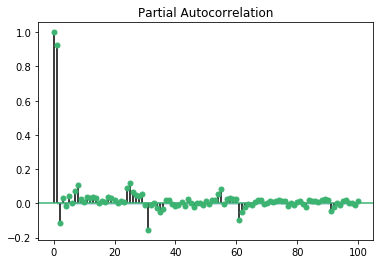

In [13]:
#plt.rcParams.update({'font.size': 22})
#plt.figure(figsize = (24,16))
sm.graphics.tsa.plot_pacf(akamai.iloc[1:]['dropped'], lags=100, ax=plt.gca(), color='mediumseagreen')
    
plt.savefig('pacf_plot2.png')

KeyboardInterrupt: 

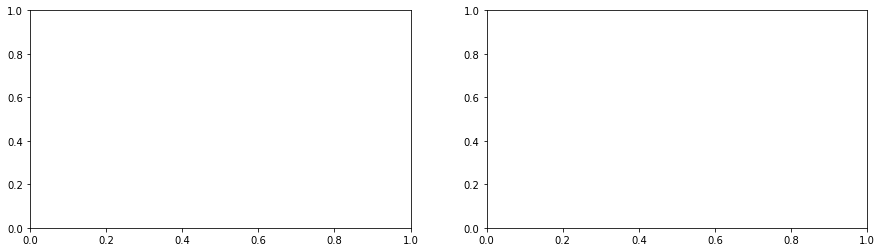

In [14]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_pacf(akamai.iloc[1:]['dropped'], lags=10000, ax=axes[1])
fig = sm.graphics.tsa.plot_acf(akamai.iloc[1:]['dropped'], lags=60, ax=axes[1])

In [15]:
import statsmodels.api as sm

# Fit the model
mod = sm.tsa.statespace.SARIMAX(akamai['dropped'], trend='c', order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                dropped   No. Observations:                44640
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -515794.668
Date:                Sun, 25 Nov 2018   AIC                        1031597.337
Time:                        10:26:03   BIC                        1031632.162
Sample:                    07-01-2016   HQIC                       1031608.303
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.483e+04    284.888     52.068      0.000    1.43e+04    1.54e+04
ar.L1          0.9143      0.001   1055.388      0.000       0.913       0.916
ma.L1          0.1225      0.001     88.362      0.0

In [16]:
# However, we want to introduce seasonality.
# Namely, because the data is quarterly, we may want to fit: y(t)=c+phi(1)y(t-1)+theta(1)e(t-1)+theta(4)e(t-4)+e(t)
# We can do that.

ar = 1          # this is the maximum degree specification
ma = (1,0,0,1)  # this is the lag polynomial specification
mod = sm.tsa.statespace.SARIMAX(akamai['dropped'], trend='c', order=(ar,1,ma))
res = mod.fit(disp=False)
print(res.summary())

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


                             Statespace Model Results                            
Dep. Variable:                   dropped   No. Observations:                44640
Model:             SARIMAX(1, 1, (1, 4))   Log Likelihood             -515689.022
Date:                   Sun, 25 Nov 2018   AIC                        1031388.045
Time:                           10:34:03   BIC                        1031431.576
Sample:                       07-01-2016   HQIC                       1031401.753
                            - 08-01-2016                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9753      4.190      0.233      0.816      -7.238       9.188
ar.L1          0.8118      0.002    370.686      0.000       0.807       0.816
ma.L1         -0.8902      0

In [17]:
# Fit an ARIMA(1,1,1) model
mod = sm.tsa.statespace.SARIMAX(akamai['dropped'], trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                dropped   No. Observations:                44640
Model:               SARIMAX(1, 1, 1)   Log Likelihood             -516729.688
Date:                Sun, 25 Nov 2018   AIC                        1033467.376
Time:                        10:34:17   BIC                        1033502.202
Sample:                    07-01-2016   HQIC                       1033478.343
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7276    199.439      0.004      0.997    -390.165     391.620
ar.L1         -0.5311      0.012    -42.839      0.000      -0.555      -0.507
ma.L1          0.6156      0.012     51.323      0.0

In [23]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(akamai['dropped'], order=(2,0,3), seasonal_order=(1,0,1,12), simple_differencing=True, enforce_stationarity=False, enforce_invertibility=False)
res = mod.fit(disp=False)
print(res.summary())

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                            dropped   No. Observations:                44640
Model:             SARIMAX(2, 0, 3)x(1, 0, 1, 12)   Log Likelihood             -515627.510
Date:                            Sun, 25 Nov 2018   AIC                        1031271.021
Time:                                    10:47:57   BIC                        1031340.669
Sample:                                07-01-2016   HQIC                       1031292.953
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7319      0.004    478.027      0.000       1.725       1.739
ar.L2         -0.7323      0.004   

In [35]:
ss_res = sum(res.resid**2)
ss_total = sum((akamai['dropped']- akamai['dropped'].mean())**2)

K = 7
n = 4460

r_squared = 1 - (ss_res/ss_total)
adj_r_squared = 1 - ((ss_res/(n-K))/(ss_total/(n-1)))

In [36]:
r_squared

0.8539480626969801

In [38]:
adj_r_squared

0.8537512714048584